# Прогнозирование оттока клиентов.

**Описание проекта.**


Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.


**Описание услуг.**


Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).


Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).


За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Цель проекта** - построение модели, определяющей отточных клиентов, т. е. решающей задачу бинарной классификации.

Исследуемая метрика: AUC-ROC.

Критерии оценки: AUC-ROC >= 0.85



# План проекта.
- Загрузка данных.
  - Просмотр основной информации о датафреймах.
  - Проверка данных на явные и неявные дубликаты.
  - Проверка данных на пропуски.
  - Выводы по разделу.
- Обработка данных.
  - Объединение таблиц.
  - Заполнение пропусков.
  - Замена типов данных.
  - Создание целевого признака.
  - Удаление далее не нужных входных признаков.
  - Построение графиков.
  - Проверка корреляций.
  - Разбиение исходных данных на тренировочную и тестовую выборку.
  - Кодирование категориальных признаков.
  - Стандартизация численных признаков.
  - Выводы по разделу.
- Обучение моделей.
  - Выбор моделей, которые будут участвовать в сравнении.
  - Обучение выбранных моделей на тренировочной выборке с кросс-валидацией и подбором наилучших гиперпараметров.
  - Сравнение результатов, выбор наилучшей в данном случае модели.
  - Выводы по разделу.
- Тестирование выбранной модели.
  - Обучение на тестовой выборке, получение предсказания, подсчёт метрики.
  - Сравнение полученного значения метрики с требуемым.
  - Интерпретация модели: рассмотрения влияния признаков на результат.
  - Выводы по разделу.
- Общие выводы по проекту.

# Загрузка данных.

Загружаем необходимые для работы библиотеки и данные.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

!pip install phik
from phik import report
from phik.report import plot_correlation_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler

!pip install catboost
from catboost import CatBoostClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
try:
    df_contract = pd.read_csv(
        '/content/drive/MyDrive/Colab Notebooks/Datasets/Final_project/contract_new.csv',
        sep=',',
    )
    df_internet = pd.read_csv(
        '/content/drive/MyDrive/Colab Notebooks/Datasets/Final_project/internet_new.csv',
        sep=',',
    )
    df_personal = pd.read_csv(
        '/content/drive/MyDrive/Colab Notebooks/Datasets/Final_project/personal_new.csv',
        sep=',',
    )
    df_phone = pd.read_csv(
        '/content/drive/MyDrive/Colab Notebooks/Datasets/Final_project/phone_new.csv',
        sep=',',
    )
except:
    df_contract = pd.read_csv('/datasets/contract_new.csv', sep=',')
    df_internet = pd.read_csv('/datasets/internet_new.csv', sep=',')
    df_personal = pd.read_csv('/datasets/personal_new.csv', sep=',')
    df_phone = pd.read_csv('/datasets/phone_new.csv', sep=',')

Чтобы упростить беглый осмотр данных, всё оборачиваю в функцию, а потом применяю к каждому из датасетов.

In [4]:
def df_info(df):
    print(df.info())
    print('')
    display(df.head(10))
    print('')
    display(df.describe())
    print('')
    print(f'Количество явных дубликатов в датафрейме: {df.duplicated().sum()}.')
    print('')
    print(f'Количество неявных дубликатов в датафрейме: {df.duplicated(subset=["customerID"], keep=False).sum()}.')
    print('')
    print('Процент пропусков по столбцам:')
    display(
        pd.DataFrame(
            round(
                df.isna().mean() * 100,
                2
            )
        ).style.background_gradient('coolwarm')
    )

In [5]:
df_info(df_contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



Количество явных дубликатов в датафрейме: 0.

Количество неявных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
customerID,0.000000
BeginDate,0.000000
EndDate,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000
MonthlyCharges,0.000000
TotalCharges,0.000000


In [6]:
df_info(df_internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Количество явных дубликатов в датафрейме: 0.

Количество неявных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
customerID,0.000000
InternetService,0.000000
OnlineSecurity,0.000000
OnlineBackup,0.000000
DeviceProtection,0.000000
TechSupport,0.000000
StreamingTV,0.000000
StreamingMovies,0.000000


In [7]:
df_info(df_personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Количество явных дубликатов в датафрейме: 0.

Количество неявных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
customerID,0.000000
gender,0.000000
SeniorCitizen,0.000000
Partner,0.000000
Dependents,0.000000


In [8]:
df_info(df_phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None



,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390



Количество явных дубликатов в датафрейме: 0.

Количество неявных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
customerID,0.000000
MultipleLines,0.000000


Обозначение признаков.
- BeginDate – дата начала пользования услугами.
- EndDate – дата окончания пользования услугами.
- Type – тип оплаты: ежемесячный, годовой и тд,
- PaperlessBilling – безналичный расчет.
- PaymentMethod – способ оплаты.
- MonthlyCharges – ежемесячные траты на услуги.
- TotalCharges – всего потрачено денег на услуги.
- Dependents – наличие иждивенцев.
- Senior Citizen – наличие пенсионного статуса по возрасту.
- Partner – наличие супруга(и).
- MultipleLines – наличие возможности ведения параллельных линий во время
звонка.

## Выводы по разделу.
- Необходимые библиотеки и данные, с которыми будем работать, загружены.
- В данных есть как числовые, так и категориальные признаки.
- Есть ряд столбцов, чей тип данных необходимо заменить: например, даты из первой таблицы или TotalCharges, который должен быть float.
- Дубликаты в таблицах не обнаружены.
- Пропусков в таблицах по отдельности тоже нет. Однако их разный размер говорит нам о том, что когда мы объединим все датафреймы в один по значениям столбца 	customerID, в этой финальной таблице с 7043 строками пропуски будут, и их надо будет обработать.
- Из представленных в таблицах в качестве целевого выбираем признак EndDate, однако прямо в таком виде использовать мы его не можем. Далее на основе него будет создан отдельный признак, который пойдёт в модели, а даты начала и конца контракта будут заменены на признак, показывающий сколько дней человек являлся (или является) клиентом.

# Обработка данных.

Объединим все таблицы в одну по общему столбцу CustomerID.

In [9]:
df = (
    df_contract.merge(df_internet, on='customerID', how='outer')
    .merge(df_personal, on='customerID', how='outer')
    .merge(df_phone, on='customerID', how='outer')
)

In [10]:
df_info(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Fiber optic,No,No,Yes,No,Yes,Yes,Female,0,No,No,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Fiber optic,No,Yes,No,No,Yes,No,Male,0,No,Yes,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,DSL,Yes,No,No,No,No,No,Female,0,No,No,NaN
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Fiber optic,No,No,Yes,Yes,Yes,Yes,Female,0,Yes,No,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,DSL,Yes,Yes,No,No,No,No,Male,0,No,Yes,No


,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000
mean,64.761692,0.162147
std,30.090047,0.368612
min,18.250000,0.000000
25%,35.500000,0.000000
50%,70.350000,0.000000
75%,89.850000,0.000000
max,118.750000,1.000000



Количество явных дубликатов в датафрейме: 0.

Количество неявных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
customerID,0.000000
BeginDate,0.000000
EndDate,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000
MonthlyCharges,0.000000
TotalCharges,0.000000
InternetService,21.670000
OnlineSecurity,21.670000


Как и говорилось выше, получили пропуски. Отсутствие информации в данном говорит о том, что скорее всего данные клиенты не являются пользователями рассматриваемых услуг. Делаем везде замену на No.

In [11]:
df = df.fillna('No')

Проверим значения бинарных признаков, имеющих значение 'Yes' или 'No'.

In [12]:
bin_yes_no_list = [
    'PaperlessBilling',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'Partner',
    'Dependents',
    'MultipleLines',
]

for column in bin_yes_no_list:
    print(df[column].unique())

['Yes' 'No']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']


Обнаружено разное написание отрицательного варианта, приведём к единому виду.

In [13]:
for column in bin_yes_no_list:
  df[column] = df[column].replace('no', 'No')

При попытке смены типа данных у столбца с суммарными платежами были обнаружены не учтённые ранее пропуски (в виде пробела), которые не дают поменять типа данных, заменим их на NaN.

In [14]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(float)

Смотрим, сколько их.

In [15]:
df['TotalCharges'].isna().sum()

11

Смотрим, что это за клиенты с пропусками.

In [16]:
df[df['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,No,No,No,No,No,No,No,Male,0,No,Yes,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,No,No,No,No,No,No,No,Male,0,Yes,Yes,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,No,No,No,No,No,No,No,Male,0,Yes,Yes,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,No,No,No,No,No,No,No,Male,0,Yes,Yes,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,No,No,No,No,No,No,No,Female,0,Yes,Yes,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,No,No,No,No,No,No,No,Male,0,Yes,Yes,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,DSL,No,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes


Пропуски у новых клиентов, которые только что заключили контракт. Заменяем пропуски на значение их месячной платы.

In [17]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'])

Создадим на основе столбца EndDate полноценные целевой признак, где единица будет обозначать ушедшего клиента, а 0 активного.

In [18]:
df['Exited'] = np.where(df['EndDate'] == 'No', 0, 1)

Для тех, кто не ушёл, выставим в столбце EndDate дату выгрузки датасета.

In [19]:
df['EndDate'] = df['EndDate'].replace('No', '2020-02-01')

Приведём столбцы с датами к правильному типу данных.

In [20]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate'] = pd.to_datetime(df['EndDate'])

На их основе создадим признак в виде стажа клиента в днях. Исходные столбцы вместе с беполезным для дальнейшего машинного обучения столбцом customerID удаляем.

In [21]:
df['Tenure'] = (df['EndDate'] - df['BeginDate']).dt.days
df = df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

Смотрим, как распределились клиенты по своему стажу.

In [22]:
df['Tenure'].describe()

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: Tenure, dtype: float64

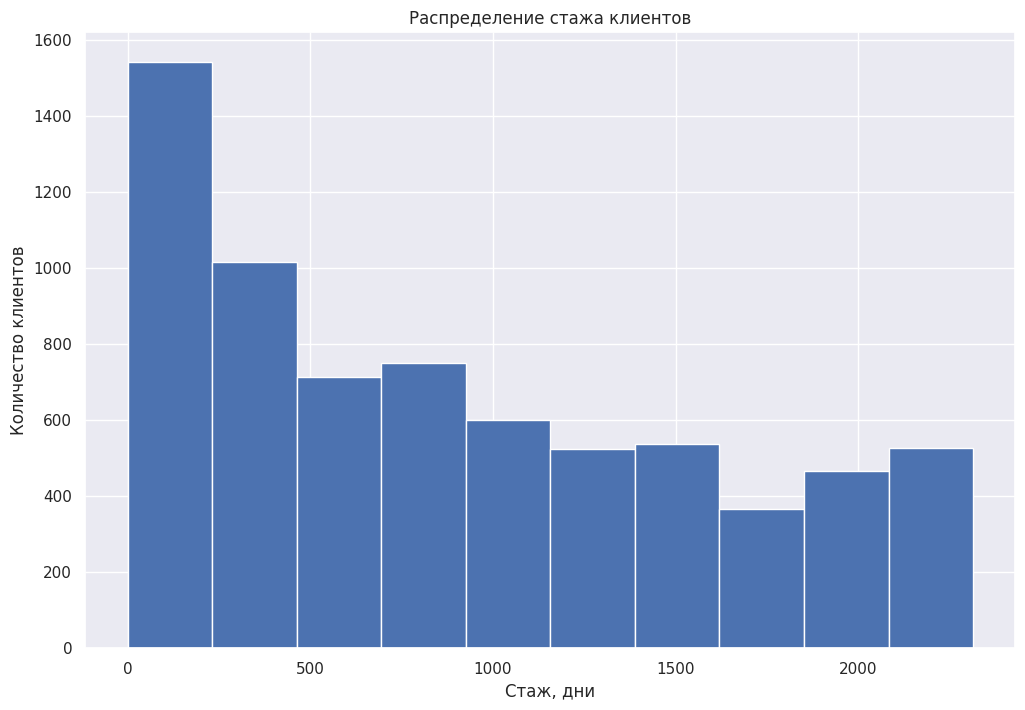

In [23]:
sns.set(rc={'figure.figsize':(12, 8)})
df['Tenure'].hist();
plt.xlabel('Стаж, дни')
plt.ylabel('Количество клиентов')
plt.title('Распределение стажа клиентов')
plt.show()

Больше всего клиентов, которые с провайдером до года, однако и 'старожилов' не так уж и мало. Из-за них есть разница между между медианным и среднеарифметическим значениями стажа: 761 день против 899 дней.

Провреяем классы целевого признака на дисбаланс.

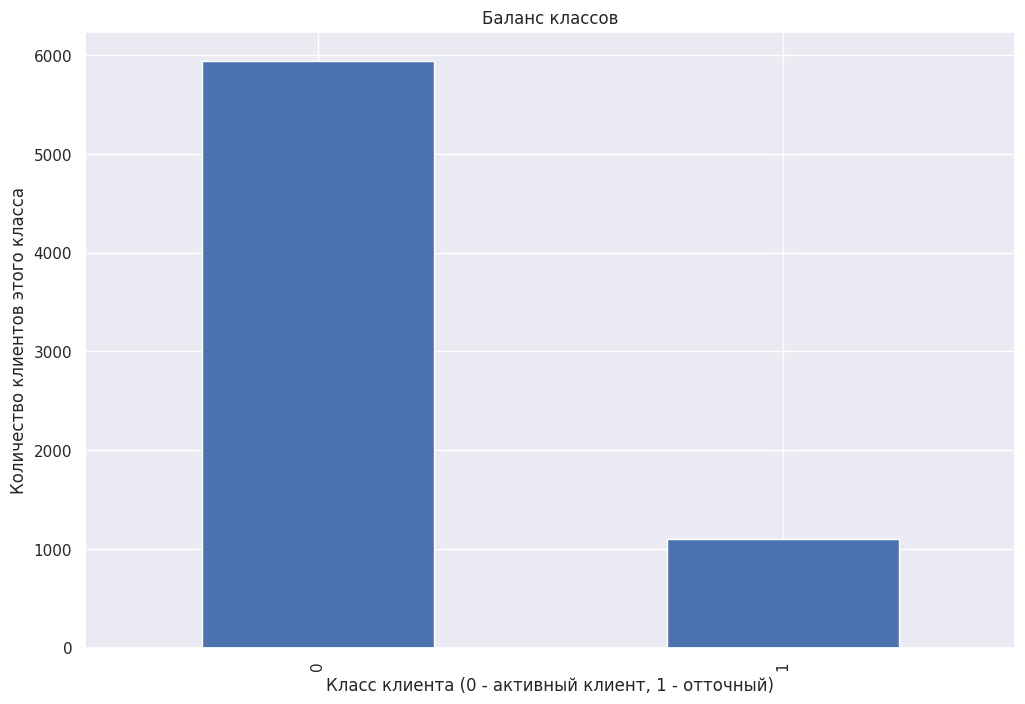

In [24]:
class_counts = df['Exited'].value_counts()

sns.set(rc={'figure.figsize':(12, 8)})
class_counts.plot(kind='bar')
plt.xlabel('Класс клиента (0 - активный клиент, 1 - отточный)')
plt.ylabel('Количество клиентов этого класса')
plt.title('Баланс классов')
plt.show();

На лицо явный дисбаланс классов.

Смотрим, как отличается стаж отточников и активных клиентов. Сравниваем по медианному значению.

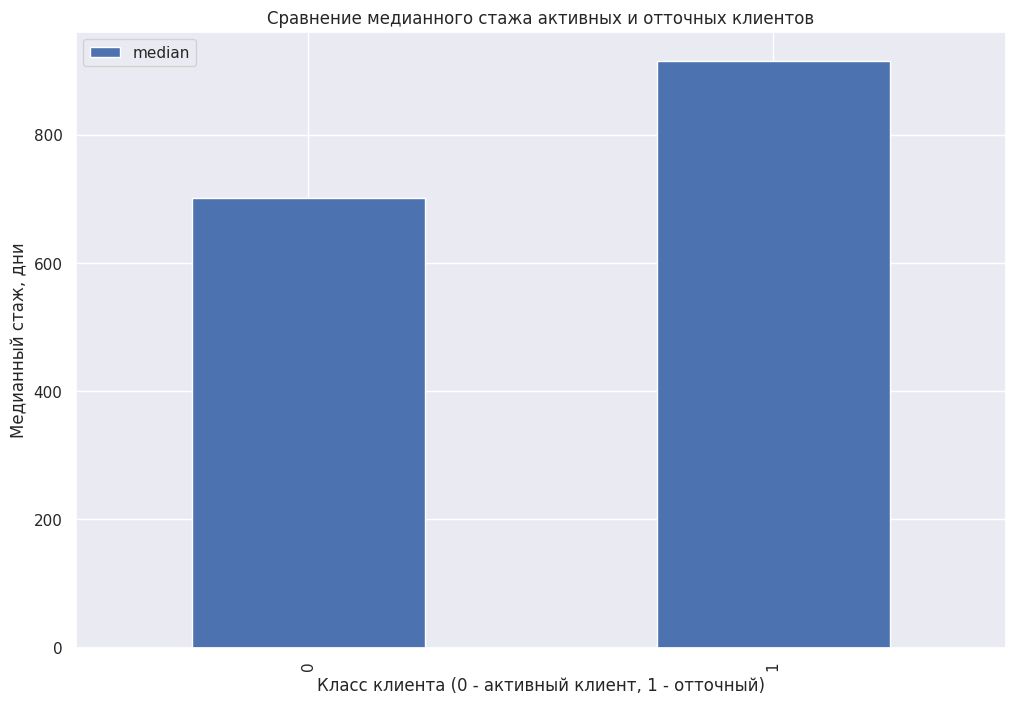

In [25]:
tenure_median = df.groupby('Exited')['Tenure'].agg(['median']).sort_values(by='median')

sns.set(rc={'figure.figsize':(12, 8)})
tenure_median.plot(kind='bar')
plt.xlabel('Класс клиента (0 - активный клиент, 1 - отточный)')
plt.ylabel('Медианный стаж, дни')
plt.title('Сравнение медианного стажа активных и отточных клиентов')
plt.show();

Выяснили таким образом, что отточники являлись клиентами в среднем дольше, чем ныне активные клиенты.

Сравниваем месячные и общие платы активных и ушедших клиентов. Сравнение также производим по медианным величинам.

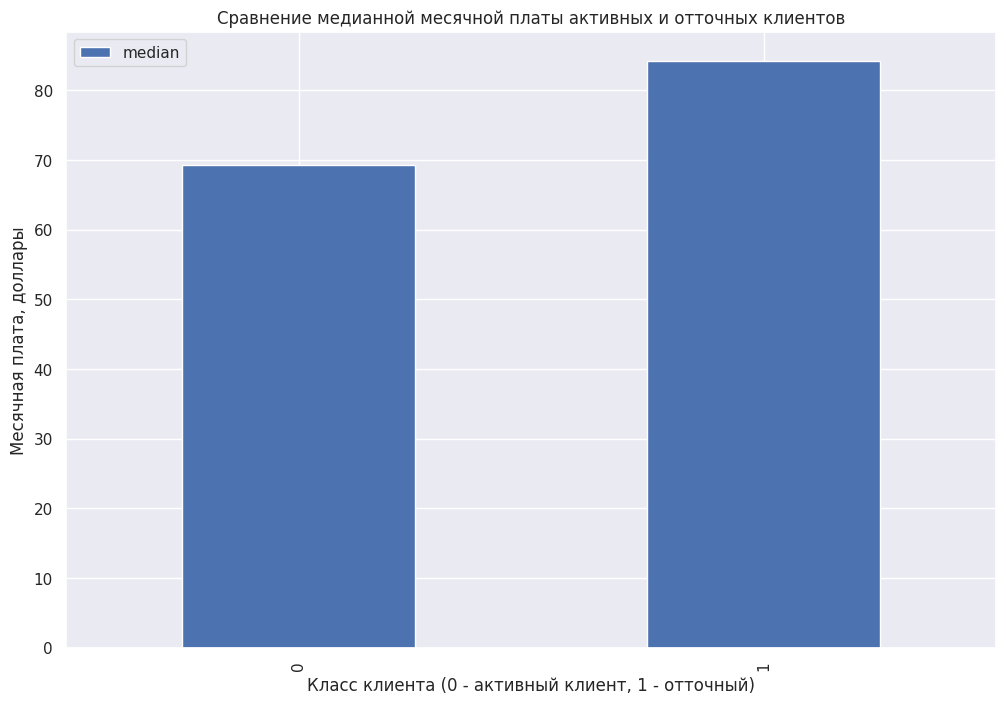

In [26]:
monthly_charges_median = df.groupby('Exited')['MonthlyCharges'].agg(['median']).sort_values(by='median')

sns.set(rc={'figure.figsize':(12, 8)})
monthly_charges_median.plot(kind='bar')
plt.xlabel('Класс клиента (0 - активный клиент, 1 - отточный)')
plt.ylabel('Месячная плата, доллары')
plt.title('Сравнение медианной месячной платы активных и отточных клиентов')
plt.show();

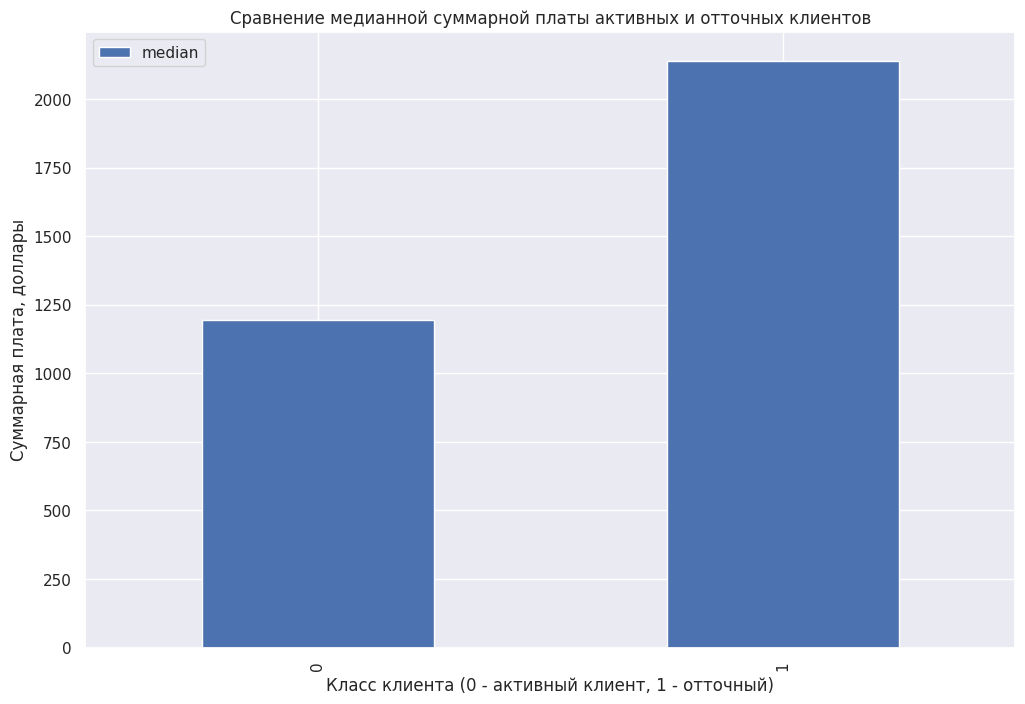

In [27]:
total_charges_median = df.groupby('Exited')['TotalCharges'].agg(['median']).sort_values(by='median')

sns.set(rc={'figure.figsize':(12, 8)})
total_charges_median.plot(kind='bar')
plt.xlabel('Класс клиента (0 - активный клиент, 1 - отточный)')
plt.ylabel('Суммарная плата, доллары')
plt.title('Сравнение медианной суммарной платы активных и отточных клиентов')
plt.show();

Видим, что в среднем ушедшие клиенты и по месяцам, и, что логично, суммарно заплатили провайдеру больше, чем ныне активные.

Смотрим, какими типами интернет-подключения пользовались (или пользуются соответственно) ушедшие и актвные клиенты. Полученные данные нормализуем, дабы их можно было сравнить, учитывая обнаруженный выше дисбалан классов.

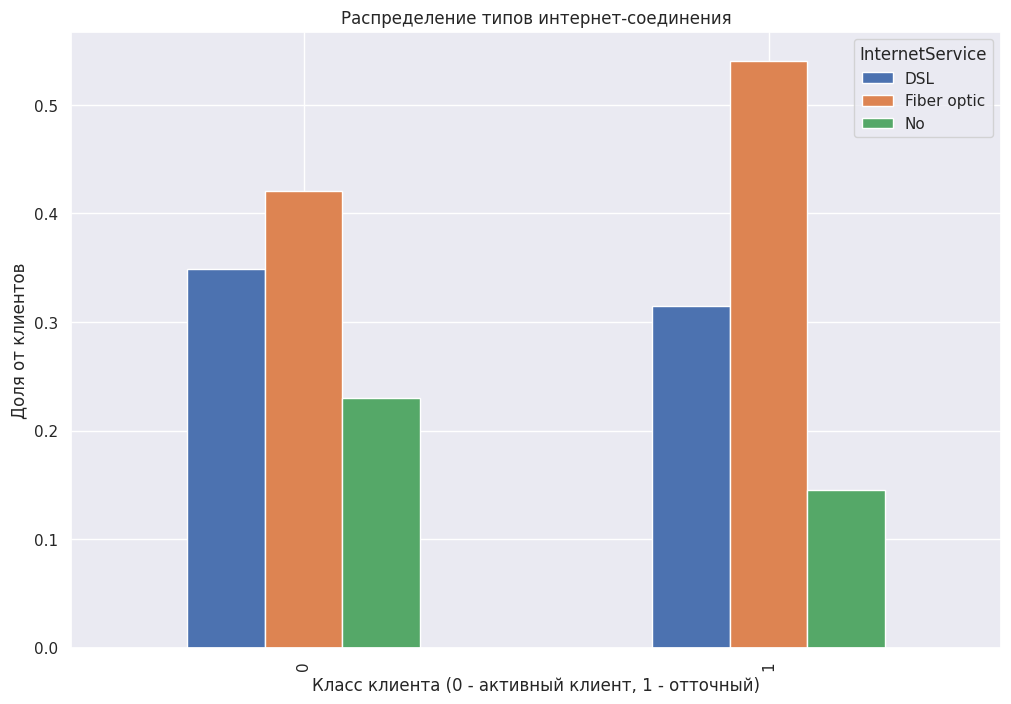

In [28]:
grouped_counts = df.groupby('Exited')['InternetService'].value_counts().unstack()
normalized_counts = grouped_counts.div(class_counts, axis=0)

sns.set(rc={'figure.figsize':(12, 8)})

normalized_counts.plot(kind='bar')

plt.xlabel('Класс клиента (0 - активный клиент, 1 - отточный)')
plt.ylabel('Доля от клиентов')
plt.title('Распределение типов интернет-соединения')

plt.show()

Исходя из графика можно сделать предположение, что лидирует подключение по оптоволокну.

Смотрим, как распределялись клиенты по каждому из параметров платежей в каждом из классов.

In [29]:
payments_list = ['Type', 'PaperlessBilling', 'PaymentMethod']

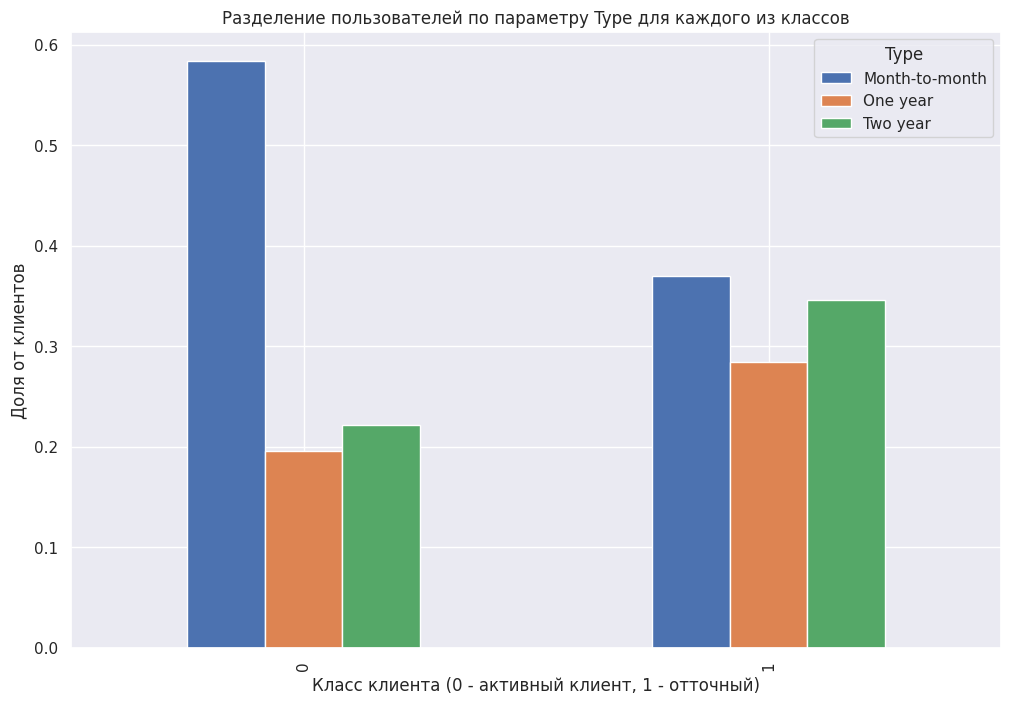

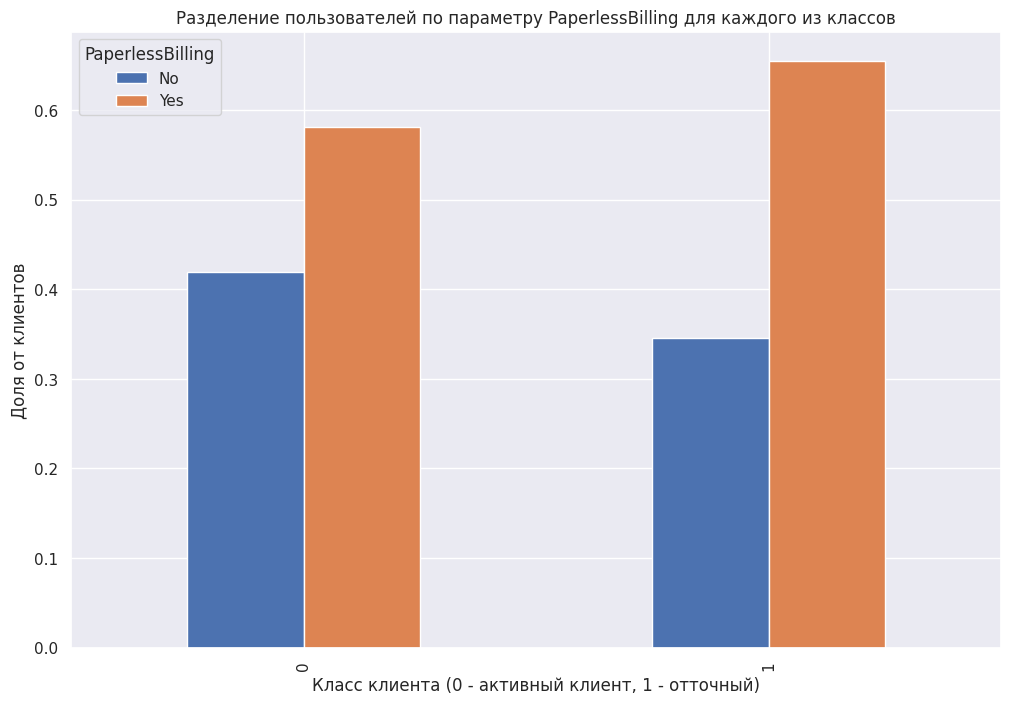

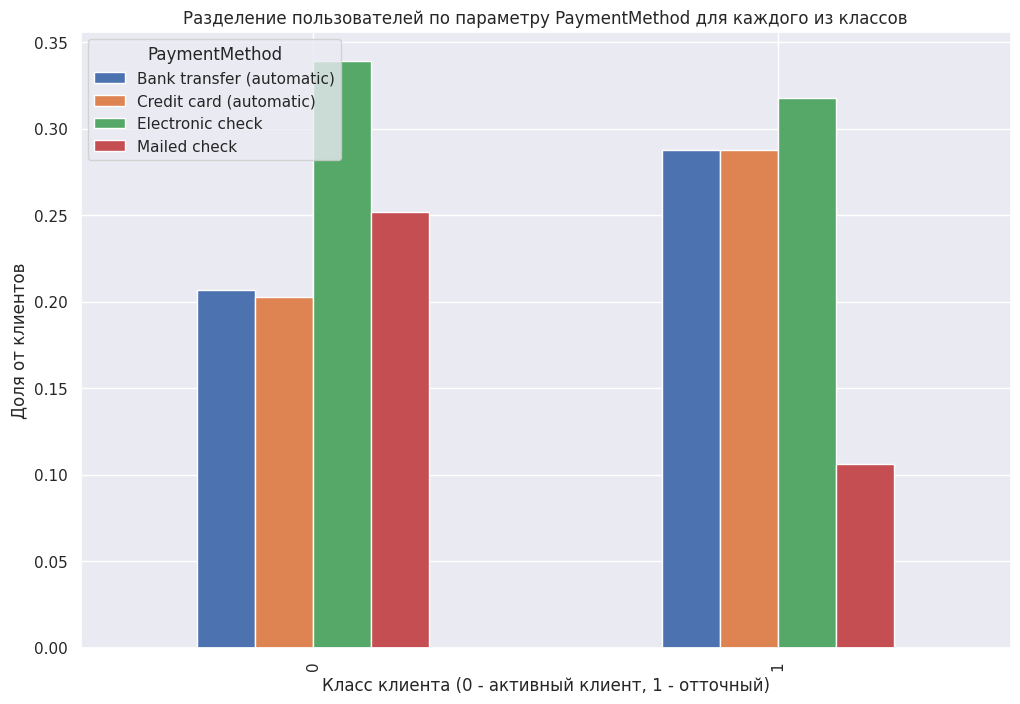

In [30]:
class_counts = df['Exited'].value_counts()

for payment in payments_list:
    grouped_counts = df.groupby('Exited')[payment].value_counts().unstack()
    normalized_counts = grouped_counts.div(class_counts, axis=0)
    sns.set(rc={'figure.figsize': (12, 8)})
    normalized_counts.plot(kind='bar')
    plt.xlabel('Класс клиента (0 - активный клиент, 1 - отточный)')
    plt.ylabel('Доля от клиентов')
    plt.title(f'Разделение пользователей по параметру {payment} для каждого из классов')
    plt.show()
    print('')


Самое важное: из сравнения медианных величин, можно сделать предположение, что cреди ушедших клиентов была большая доля тех, кто платит не по месяцам, а за более долгий период (год или два), чем среди оставшихся.

Аналогично смотрим, в каких долях распределились пользователи каждого из предлагаемых продуктов внутри классов клиентов.

In [31]:
products_list = [
    'PaperlessBilling',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines',
]

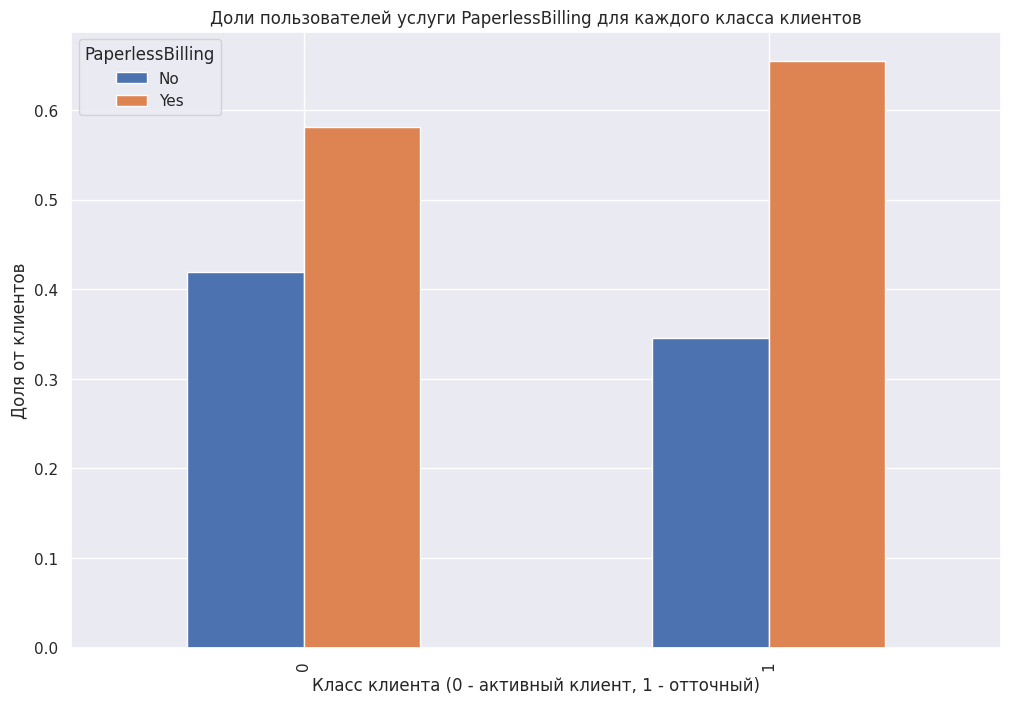

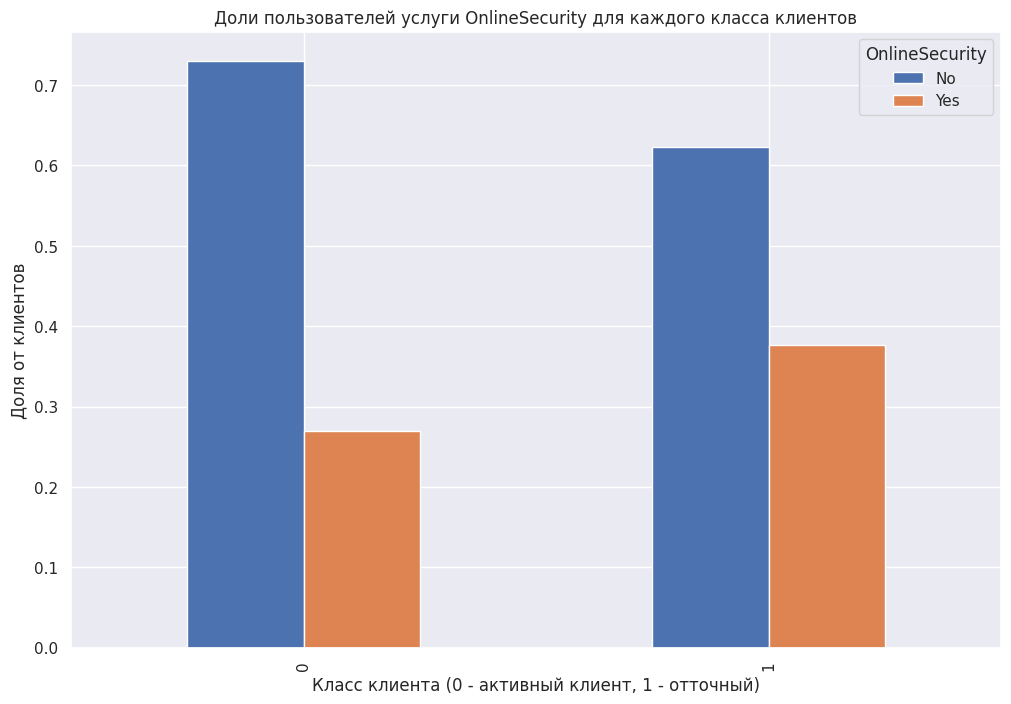

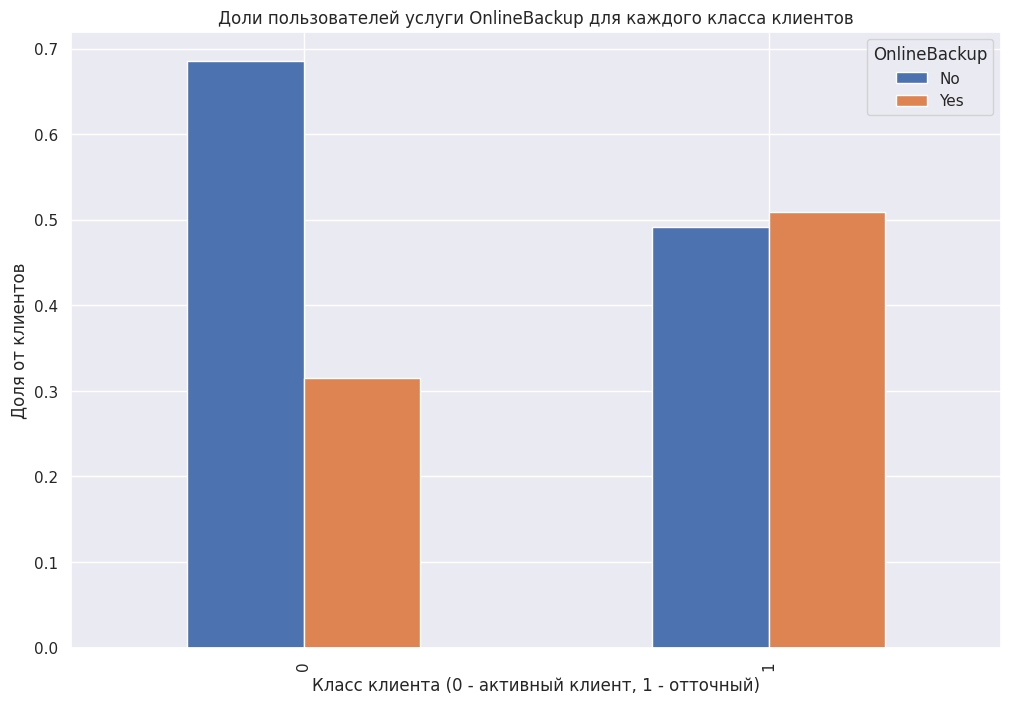

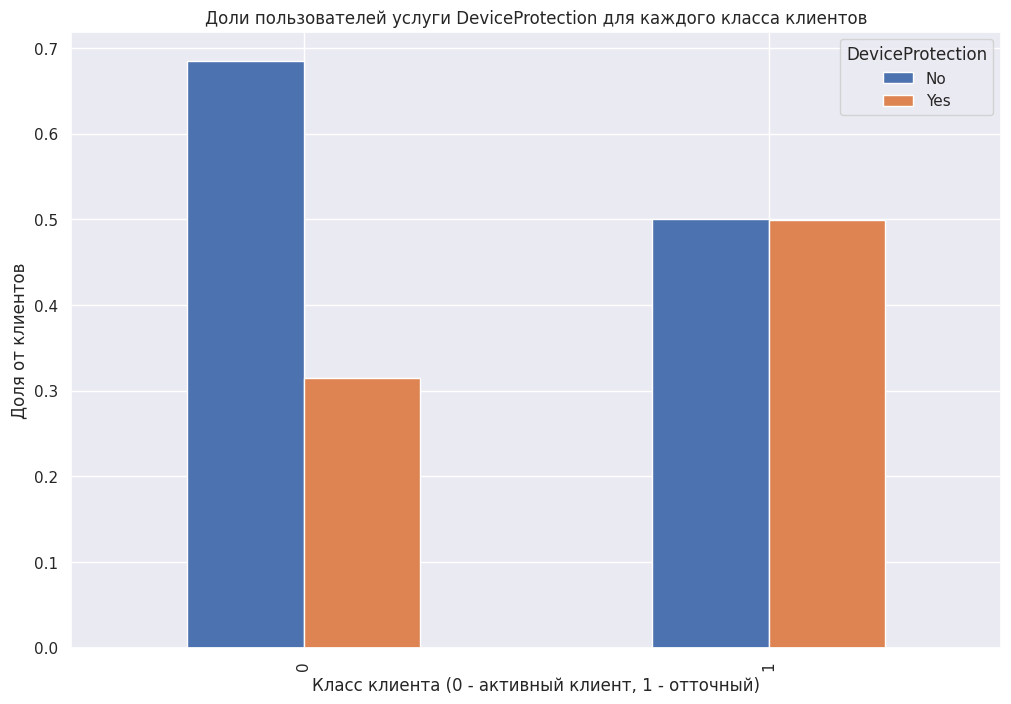

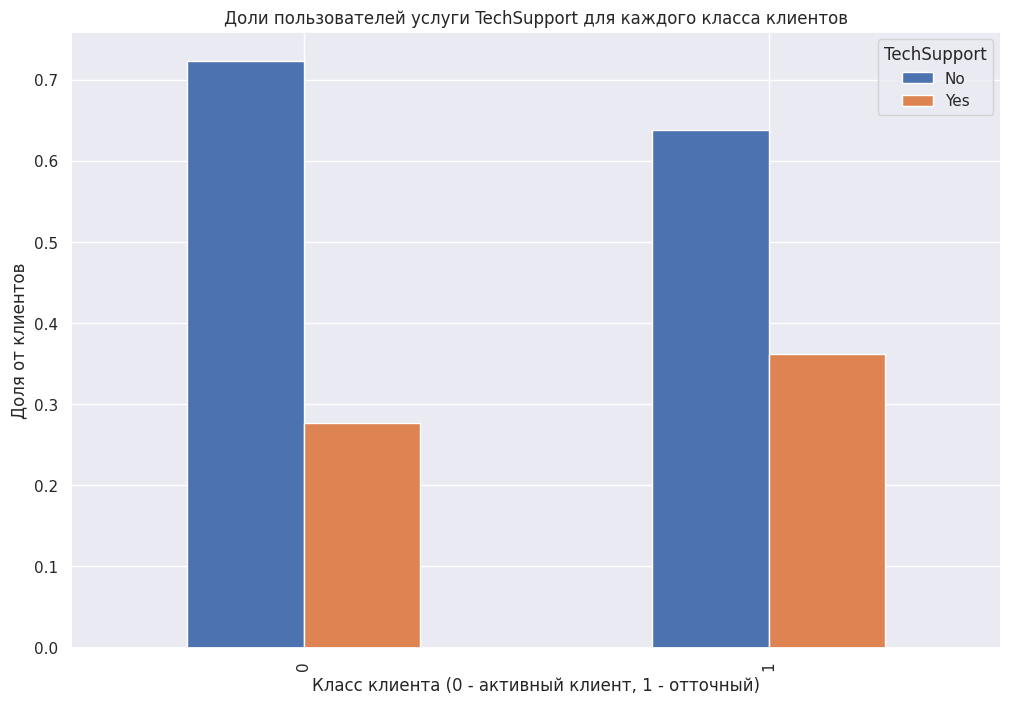

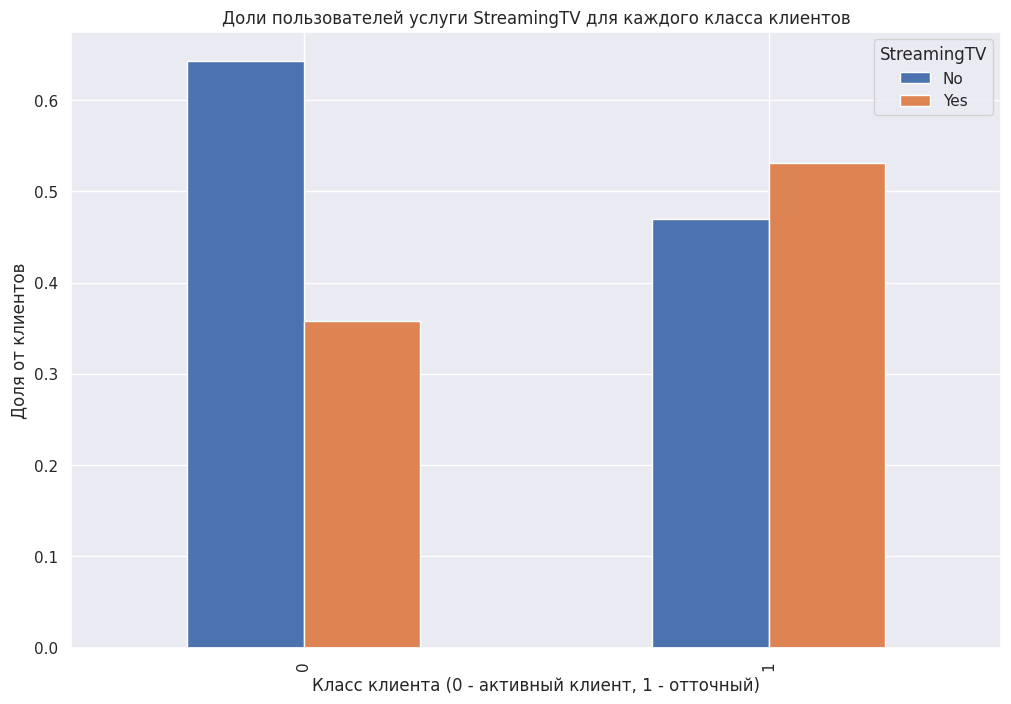

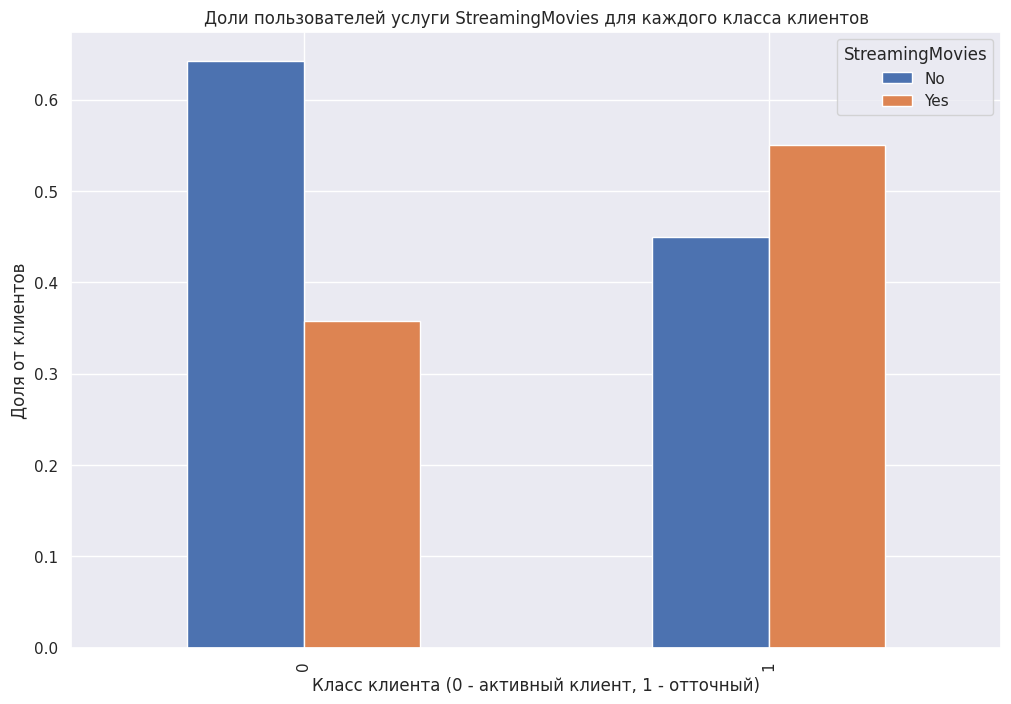

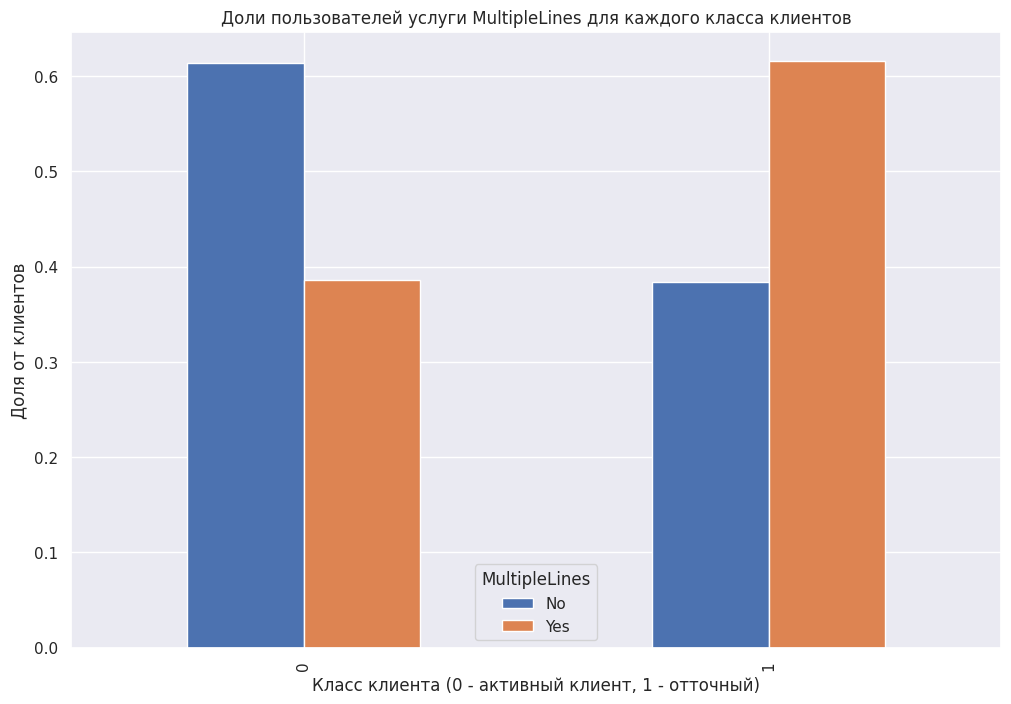

In [32]:
for product in products_list:
  grouped_counts = df.groupby('Exited')[product].value_counts().unstack()
  normalized_counts = grouped_counts.div(class_counts, axis=0)
  sns.set(rc={'figure.figsize':(12, 8)})
  normalized_counts.plot(kind='bar')
  plt.xlabel('Класс клиента (0 - активный клиент, 1 - отточный)')
  plt.ylabel('Доля от клиентов')
  plt.title(f'Доли пользователей услуги {product} для каждого класса клиентов')
  plt.show();
  print('')

Гипотеза: отточные клиенты в среднем активнее пользовались дополнительными услугами провайдера, чем те, кто остался.

Напоследок создаём список столбцов с личной информацией клиентов и смотрим разбиение по ней.

In [33]:
personal_list = ['gender',	'SeniorCitizen',	'Partner', 'Dependents']

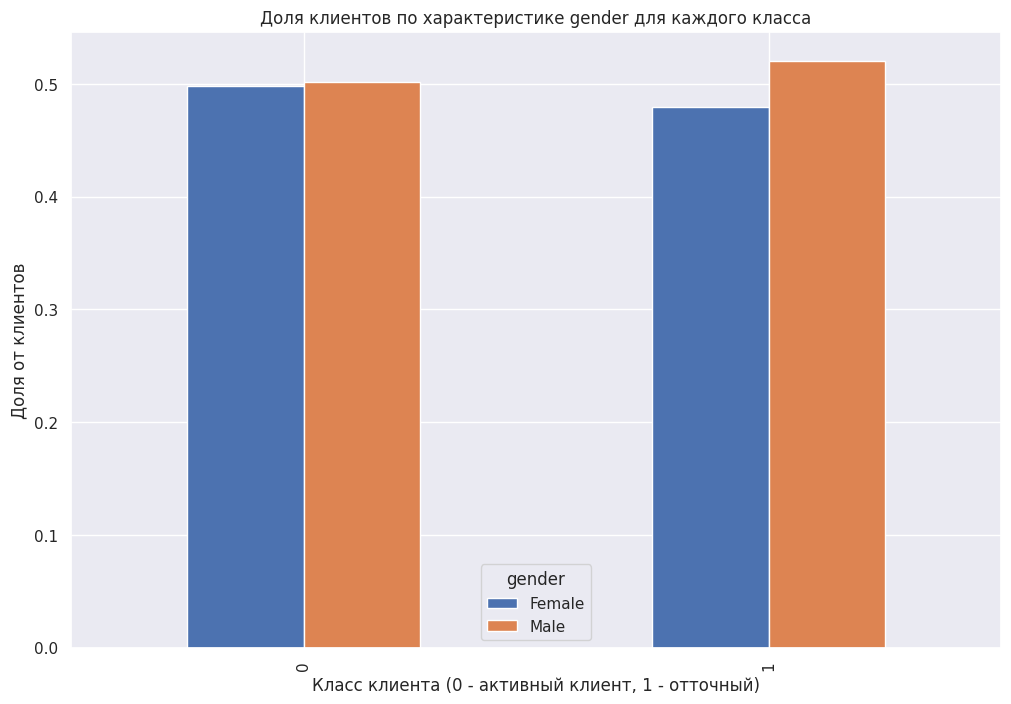

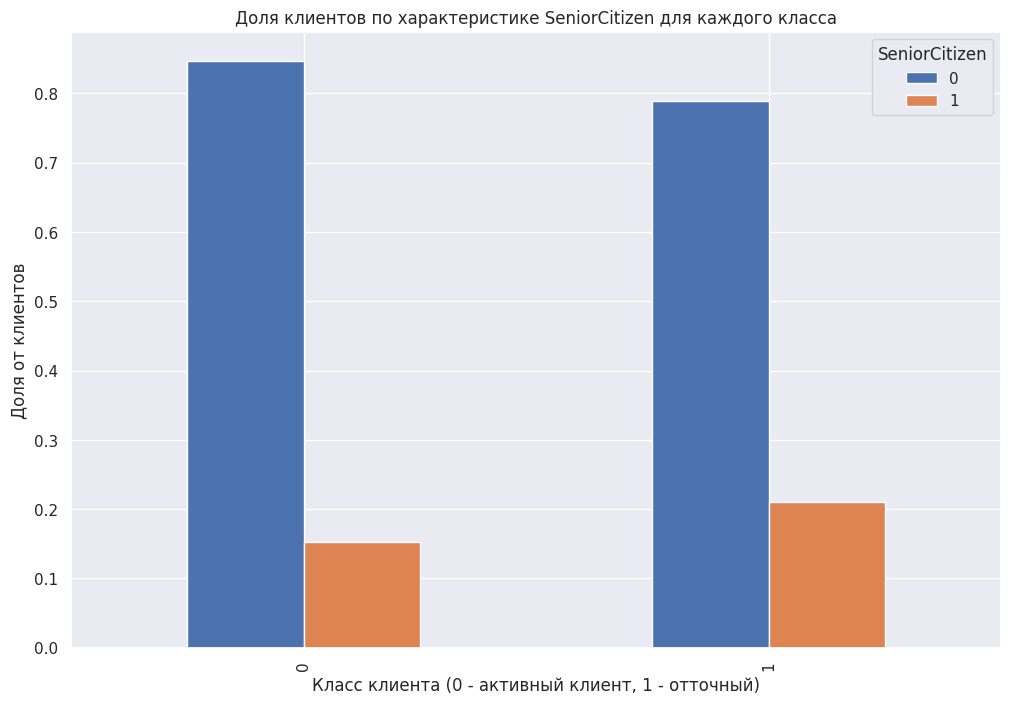

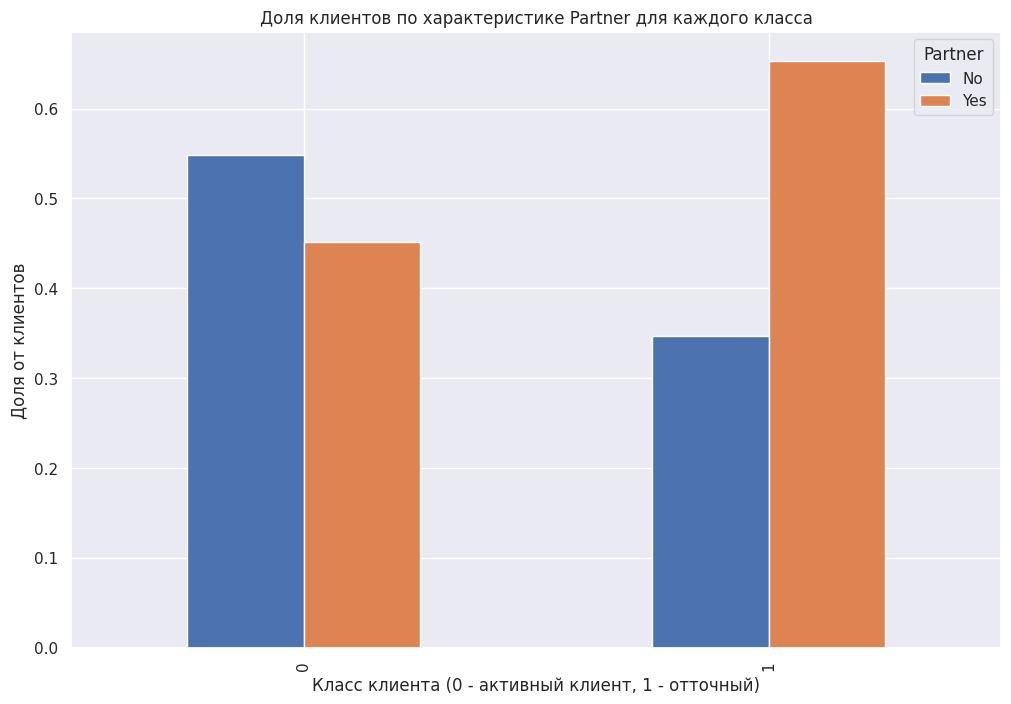

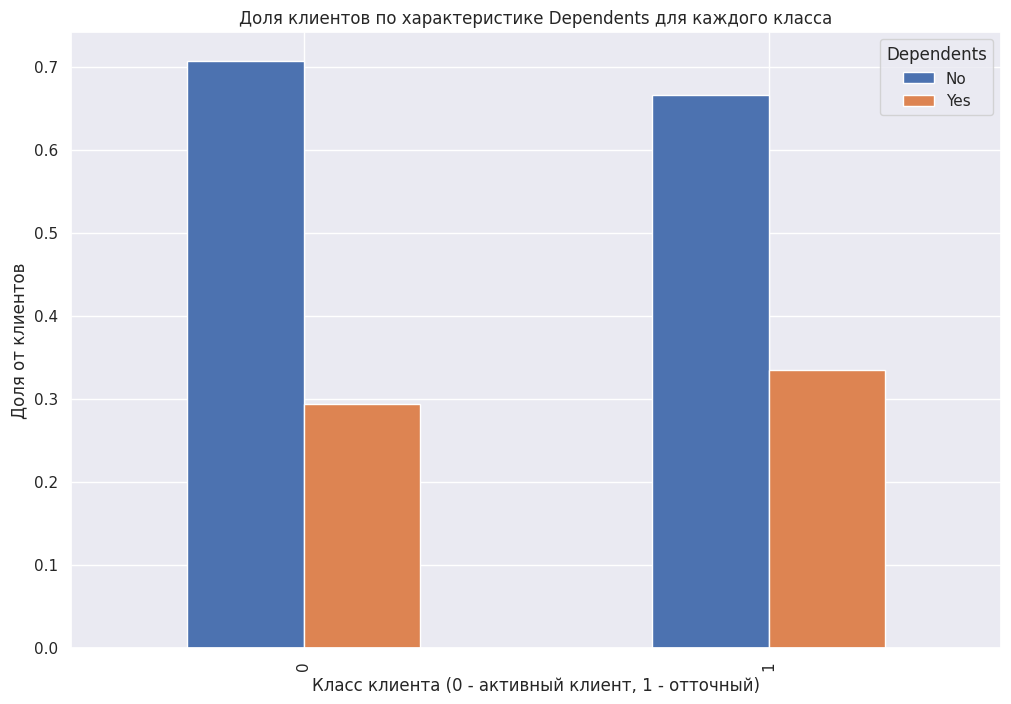

In [34]:
for info in personal_list:
  grouped_counts = df.groupby('Exited')[info].value_counts().unstack()
  normalized_counts = grouped_counts.div(class_counts, axis=0)
  sns.set(rc={'figure.figsize':(12, 8)})
  normalized_counts.plot(kind='bar')
  plt.xlabel('Класс клиента (0 - активный клиент, 1 - отточный)')
  plt.ylabel('Доля от клиентов')
  plt.title(f'Доля клиентов по характеристике {info} для каждого класса')
  plt.show();
  print('')

Исходя из сравнения медианных значений признаков, можно предположить, что среди ушедших в среднем больше людей в браке, чем среди активных клиентов.

Строим матрицу корреляций с помощью phik, который может определять и нелинейные связи между признаками. Выводим список значений коэффициента по убыванию.

In [35]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Exited', 'Tenure']


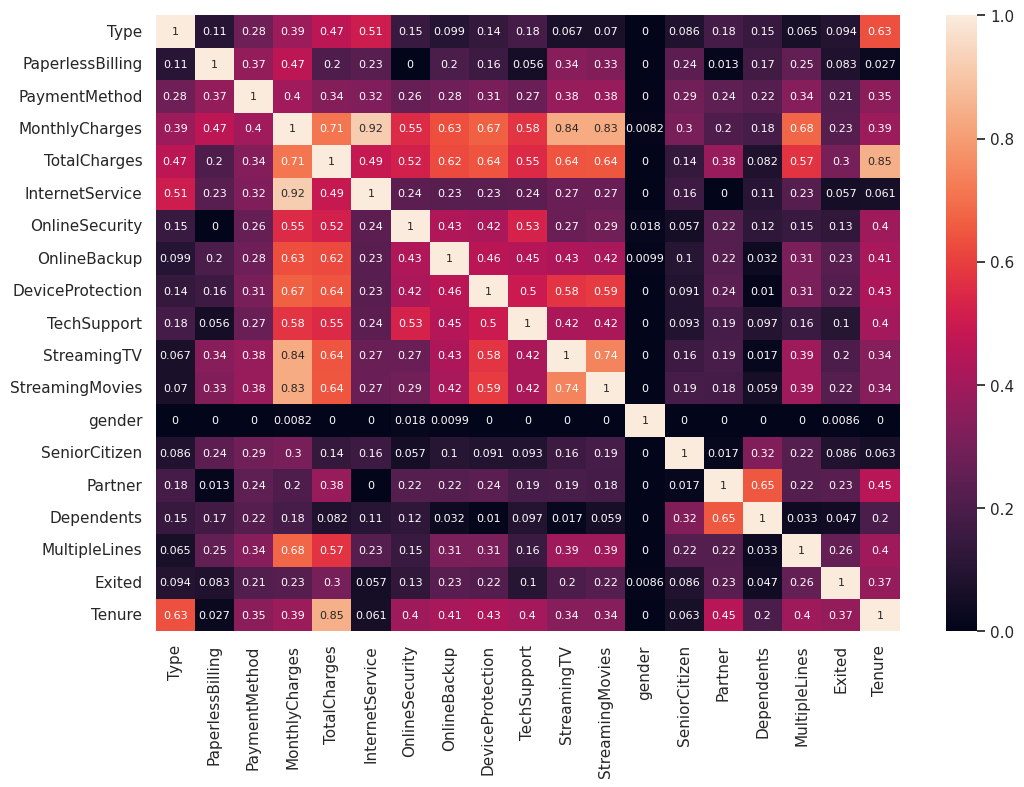

In [36]:
plt.figure(figsize=(12, 8))
sns.heatmap(phik_overview, annot=True, annot_kws={'fontsize': 8})
plt.show()

Корреляции, которые можно увидеть на этом хитмэпе достаточно логичны: например, предполагается, что если клиент оплачивает стримминговое тв, высок шанс, что оплатит и стримминговые фильмы. Или тип используемого интернет-соединения влияет на величину месячной платы, а тот клиент, у кого подключены дополнительные услуги, платит больше. Так же вполне очевидно сильно коррелируют ежемесячные и общие траты. Слабее всего на всё происходящее влияет пол клиента.



In [37]:
phik_overview['Exited'].sort_values(ascending = False)

Exited              1.000000
Tenure              0.374569
TotalCharges        0.304287
MultipleLines       0.261237
OnlineBackup        0.229482
Partner             0.226688
MonthlyCharges      0.226280
StreamingMovies     0.222232
DeviceProtection    0.218380
PaymentMethod       0.214832
StreamingTV         0.200198
OnlineSecurity      0.132594
TechSupport         0.103652
Type                0.094015
SeniorCitizen       0.086159
PaperlessBilling    0.083398
InternetService     0.056621
Dependents          0.046871
gender              0.008581
Name: Exited, dtype: float64

Предполагается, что на уход клиента больше всего влияют его стаж, суммарные платы и наличие возможности ведения параллельных линий во время звонка.

Фиксируем глобальную переменную для Random State.

In [38]:
RND_STATE = 30723

Разбиваем данные на тренировочную и тестовую выборки.

In [39]:
target = df['Exited']
features = df.drop(['Exited'], axis = 1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RND_STATE, stratify=target)

Сравниваем получившиеся размеры закодированных выборок.

In [40]:
features_train.shape

(5282, 18)

In [41]:
features_test.shape

(1761, 18)

Разделяем признаки на категориальные и числовые, к категориальным применяем кодирование с помощью OneHot Encoding.

In [42]:
cat_features_names = ['Type',	'PaperlessBilling',	'PaymentMethod', 'InternetService',	'OnlineSecurity',	'OnlineBackup',	'DeviceProtection',	'TechSupport',	'StreamingTV',	'StreamingMovies',	'gender',	'Partner',	'Dependents',	'MultipleLines']
num_features_names = ['MonthlyCharges',	'TotalCharges', 'SeniorCitizen', 'Tenure']

In [43]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

features_train_encoding = features_train.copy()
features_test_encoding = features_test.copy()

encoder_ohe.fit(features_train_encoding[cat_features_names])
new_columns = encoder_ohe.get_feature_names_out(cat_features_names)
train_ohe = pd.DataFrame(
    encoder_ohe.transform(features_train_encoding[cat_features_names]).toarray(),
    columns=new_columns,
    index=features_train.index,
)
features_train_ohe = train_ohe.join(features_train_encoding[num_features_names])

test_ohe = pd.DataFrame(
    encoder_ohe.transform(features_test_encoding[cat_features_names]).toarray(),
    columns=new_columns,
    index=features_test_encoding.index,
)
features_test_ohe = test_ohe.join(features_test_encoding[num_features_names])

Числовые признаки, не являющиеся бинарными, подвергам стандартизации.

In [44]:
not_bin_num_features_names = ['MonthlyCharges',	'TotalCharges', 'Tenure']

In [45]:
scaler = StandardScaler()

features_train_ohe_scaled = features_train_ohe.copy()
features_test_ohe_scaled = features_test_ohe.copy()

scaler.fit(features_train_ohe[not_bin_num_features_names])

features_train_ohe_scaled [not_bin_num_features_names] = scaler.transform(features_train_ohe_scaled[not_bin_num_features_names])
features_test_ohe_scaled[not_bin_num_features_names] = scaler.transform(features_test_ohe_scaled[not_bin_num_features_names])

## Выводы по разделу.
- Таблицы были объединены в одну.
- Пропуски обработаны
- Типы данных заменеы на правильные.
- Целевой признак создан, ненужные входные удалены.
- Построен ряд графиков, из которых можно сделать предположение, что отточные клиенты в среднем платили больше тех, кто ныне активен (84 доллара в месяц против 69 и 2139 долларов общих платежей против 1194). Разница в выплатах вызвана тем, что они, опять же согласнно сравнению средних величин, могли чаще подключать дополнительные услуги, а платить предпочитали сразу за одно - или двухгодичный период. Из этого мы можем сделать важный вывод: ушедшие клиенты действительно являются большой потерей для провайдера, ибо они готовы были платить много и сразу, будучи удовлетворенными качеством предоставляемых услуг. Таким образом, поставленная в данном проекте задача обоснована. А, учитывая, что и медианный показатель их стажа (915 дней) больше, чем у ныне активных клиентов (702 дня), можно предположить, что уходят к другому провайдеру они не сразу после возникновения неких проблем, так что есть время поработать с ними и заставить передумать уходить.
- Изучены корреляции признаков, мультиколлинеарности необнаружены.
- Данные разбиты на тренировочную и тестовую выборку.
- Выполнено кодирование категориальных признаков и стандартизация численных. Данные готовы к машинному обучению.

# Обучение моделей.

Будем использовать модели логистической регрессии, RandomForest и Catboost. Значение метрики ROC-AUC будет посчитано с помощью кросс-валидации на тренировочной выборке, подбор наилучших гиперпараметров будет производиться методом GridSearch.

In [46]:
model = LogisticRegression(
    random_state=RND_STATE, solver='liblinear', class_weight='balanced')

roc_auc_scores = cross_val_score(model, features_train_ohe_scaled, target_train, cv=5, scoring='roc_auc')

roc_lr_mean = np.mean(roc_auc_scores)

print(f'Среднее значение метрики ROC-AUC на обучающей выборке: {roc_lr_mean}')

Среднее значение метрики ROC-AUC на обучающей выборке: 0.7656279815979683


In [47]:
model = RandomForestClassifier(class_weight='balanced', random_state=RND_STATE)

param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15], 'min_samples_leaf': [1, 2, 4]}
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs = -1)
grid_search.fit(features_train_ohe, target_train)

print(f'Лучшие гиперпараметры: {grid_search.best_params_}')
roc_rf = grid_search.best_score_
print(f'Значение метрики ROC-AUC на обучающей выборке: {roc_rf}')

Лучшие гиперпараметры: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 300}
Значение метрики ROC-AUC на обучающей выборке: 0.8205100370350692


In [48]:
model = CatBoostClassifier(random_state=RND_STATE, auto_class_weights='Balanced', cat_features = cat_features_names)

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [4, 6, 8],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(features_train, target_train)

best_model = grid_search.best_estimator_

cv_scores = cross_val_score(best_model, features_train, target_train, cv=5, scoring='roc_auc', n_jobs = -1, verbose = 10)
roc_auc_mean_cb = np.mean(cv_scores)

print('Лучшие гиперпараметры: ', grid_search.best_params_)
print(f'Среднее значение метрики ROC-AUC на обучающей выборке: {roc_auc_mean_cb}')

Выходные данные были обрезаны до нескольких последних строк (5000).
100:	learn: 0.6604623	total: 2.5s	remaining: 4.92s
101:	learn: 0.6602587	total: 2.51s	remaining: 4.87s
102:	learn: 0.6600095	total: 2.53s	remaining: 4.83s
103:	learn: 0.6597949	total: 2.54s	remaining: 4.78s
104:	learn: 0.6595493	total: 2.55s	remaining: 4.73s
105:	learn: 0.6592981	total: 2.56s	remaining: 4.69s
106:	learn: 0.6590140	total: 2.58s	remaining: 4.65s
107:	learn: 0.6587276	total: 2.61s	remaining: 4.64s
108:	learn: 0.6584005	total: 2.64s	remaining: 4.63s
109:	learn: 0.6581486	total: 2.65s	remaining: 4.59s
110:	learn: 0.6578782	total: 2.68s	remaining: 4.57s
111:	learn: 0.6576013	total: 2.71s	remaining: 4.54s
112:	learn: 0.6573699	total: 2.72s	remaining: 4.5s
113:	learn: 0.6570029	total: 2.75s	remaining: 4.49s
114:	learn: 0.6567316	total: 2.78s	remaining: 4.47s
115:	learn: 0.6563294	total: 2.81s	remaining: 4.46s
116:	learn: 0.6560490	total: 2.82s	remaining: 4.42s
117:	learn: 0.6557040	total: 2.85s	remaining: 4.39

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.2s remaining:    9.5s


Лучшие гиперпараметры:  {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Среднее значение метрики ROC-AUC на обучающей выборке: 0.8959023106655518


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished


Сравним значения метрики, полученные в результате, отметив на графике заданный baseline.

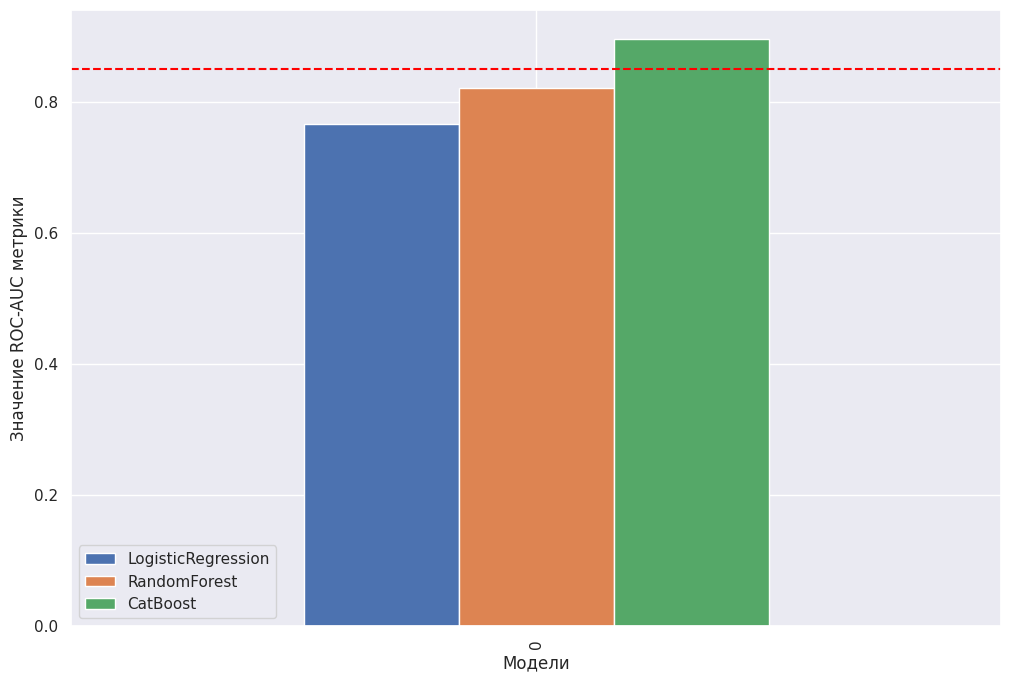

In [49]:
df_roc_auc = pd.DataFrame({'LogisticRegression': [roc_lr_mean], 'RandomForest': [roc_rf], 'CatBoost': [roc_auc_mean_cb]})

fig, ax = plt.subplots(figsize=(12, 8))
df_roc_auc.plot(kind='bar', xlabel='Модели', ylabel='Значение ROC-AUC метрики', ax=ax)
ax.axhline(y=0.85, color='red', linestyle='--')

plt.show()

## Выводы по разделу:
- Произведено сравнение моделей логистической регрессии, RandomForest и CatBoost.
- CatBoost обошёл остальные модели по величине исследуемой метрики, в случае кросс-валидации на тестовой выборке ROC-AUC равно 0.895. Таким образом эта модель стала единственной, перешедший заданный порог значения метрики, равный 0.85.
- Именно CatBoost выбираем как финальную модель, которую будем обучать на тестовых данных в следующем разделе данного проекта.

# Тестирование выбранной модели.

Обучаем лучше всего показавшую себя на тренировочной выборке тестовую модель, обучаем на тестовой, считаем значение метрики.

In [50]:
predicted_probabilities = best_model.predict_proba(features_test)[:, 1]
roc_auc = roc_auc_score(target_test, predicted_probabilities)

print(f'Значение ROC-AUC метрики на тестовой выборке: {roc_auc}')

Значение ROC-AUC метрики на тестовой выборке: 0.8939336840817325


Требуемое значение достигнуто.

Строим ROC-кривую для данной модели.

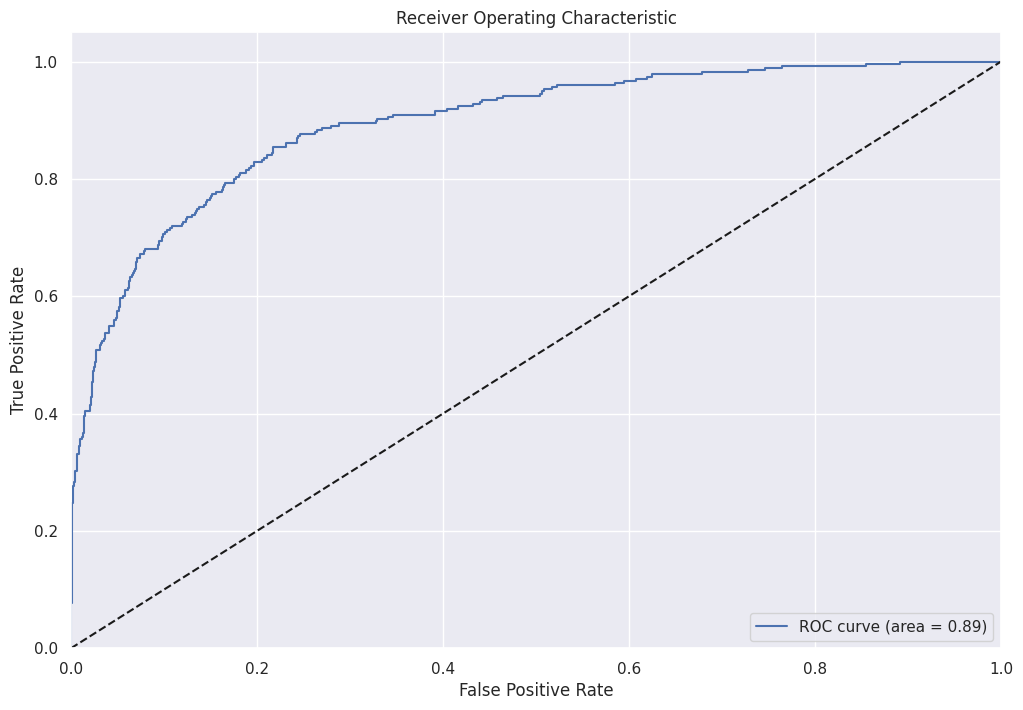

In [51]:
fpr, tpr, thresholds = roc_curve(target_test, predicted_probabilities)
roc_auc = auc(fpr, tpr)
sns.set(rc={'figure.figsize':(12, 8)})
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Теперь посмотрим, какие параметры оказались самыми важными для модели.

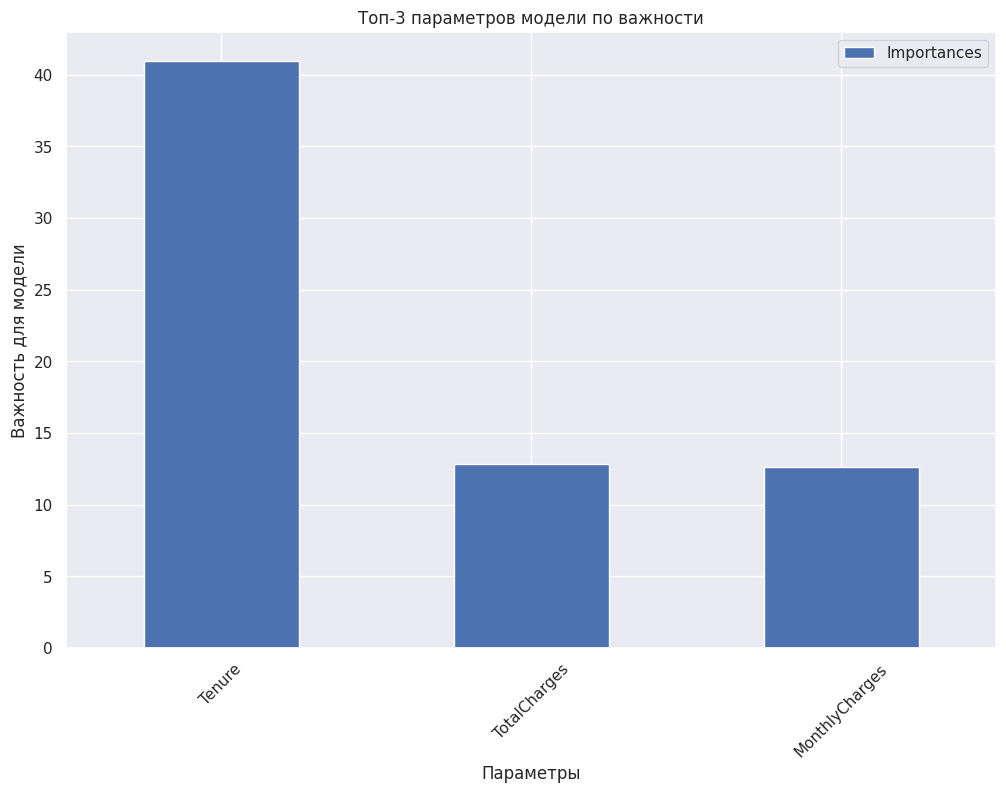

In [52]:
top_3_feature_importance = best_model.get_feature_importance(prettified=True).head(3)

sns.set(rc={'figure.figsize': (12, 8)})
top_3_feature_importance.plot(x='Feature Id', y='Importances', kind='bar')
plt.xlabel('Параметры')
plt.ylabel('Важность для модели')
plt.title('Топ-3 параметров модели по важности')
plt.xticks(rotation=45)
plt.show()

Достаточно логичный результат, на класс клиента в итоге больше всего влияет длительность его договора, суммарные и ежемесячные платы.

Для дальнейшего возможного улучшения нашей модели, посмотрим, какие признаки на результат её работы влияют меньше всего.

In [53]:
low_5_feature_importance = best_model.get_feature_importance(prettified=True).tail(5)
low_5_feature_importance

,Feature Id,Importances
13,SeniorCitizen,1.258721
14,StreamingTV,1.148853
15,DeviceProtection,1.125877
16,TechSupport,0.787740
17,OnlineSecurity,0.746385


В случае продолжения работы над моделью эти параметры можно из неё убрать в целях оптимизации.

Посмотрим теперь матрицу ошибок нашей финальной модели.

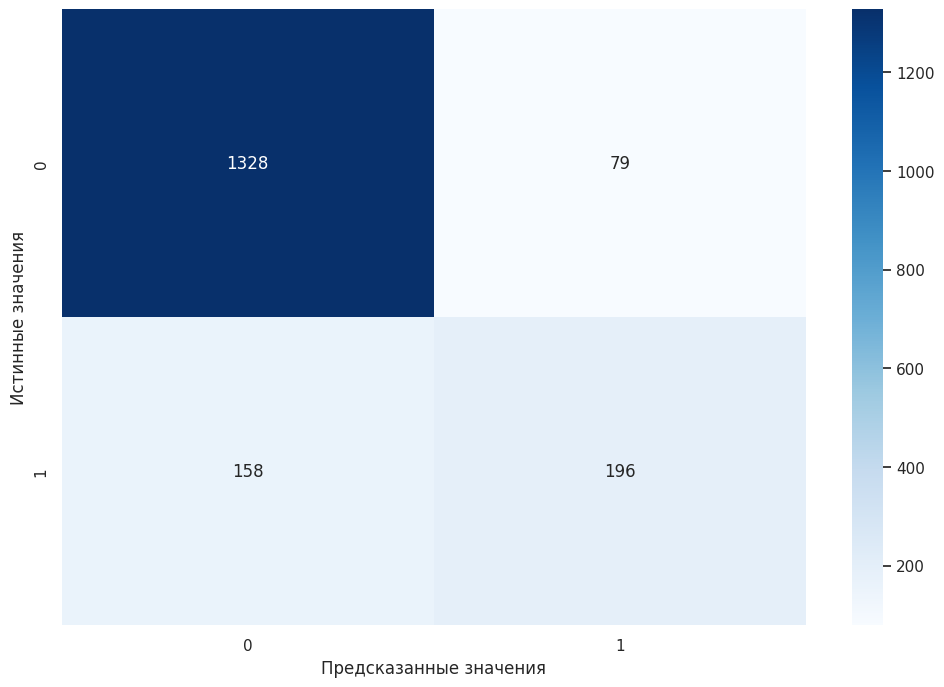

In [54]:
cm = confusion_matrix(best_model.predict(features_test), target_test)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True,  fmt='d', cmap='Blues')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.show()

## Выводы по разделу.
- Выбранная в предыдущем разделе модель обучена на тестовых данных, полученное значение метрики 0.893.
- На результат предсказания модели сильнее всего влияют показатели стажа клиента и суммы его платежей.
- Итоговая модель хорошо справляется с определением активных клиентов, но отточных клиентов часто не распознаёт верно. Учитывая, что именно ложноотрицательная оценка класса клиента по сути является нашей основной проблемой в рамках данного проекта, с целью решения реальных задач можно продолжить дальнейшую оптимизацию модели в этом направлении.

# Общие выводы.
В рамках этого проекта были рассмотрены данные о клиентах, заполнены пропуски в них и заменены неверные типы данных. На основе исходной информации был создан целевой признак, определяющий, является ли каждый конкретный клиент активным или отточным.

Путём группировки данных и построения графиков выявлены зависимости для каждого из двух классов клиентов. В частности, таким образом была обоснована задача данного проекта, так как была выдвинута гипотеза: ушедшие клиенты в среднем более платёжеспособны, чем ныне активные (медианные значения 84 доллара в месяц против 69 и 2139 долларов общих платежей против 1194 соответственно).

Далее наши данные были разбиты на тренировочную и тестовую выборки, категориальные признаки подвергнуты кодированию, а числовые стандартизации, дабы с ними могли нормально работать модели машинного обучения.

На тренировочной выборке путём кросс-валидации были обучены три модели: логистическая регрессия, RandomForest и CatBoost. Для каждой из моделей было посчитано значение метрики ROC-AUC. Только для CatBoost оно оказалось выше заданного порогового значения (0.895 у модели, пороговое значение 0.85).

Далее эта модель с подобранными гиперпараметрами была обучне на тестовой выборке. Значение илсследуемой метрики на ней стало равно 0.893, т. е. заданный порог опять же оказался пройден.

Для финальной модели была рассмотрена важность входных параметров, оказалось, что больше всего на результат влияют стаж клиента и его платежи. Соответственно, провайдеру стоит повнимательнее присматриваться к тем, кто давно является их клиентом и платит в среднем больше. Были рассмотрены и наименее влияющие на результат параметры, которые можно убрать в случае дальнейшей проработки модели.

Также для этой модели была построена матрица ошибок, из которой был сделан вывод, что в случае применения в решении реальных бизнес-задач выбранной модели можно попробовать провести её дальнейшую оптимизацию с точки зрения снижения количества ложноотрицательных оценок класса.